* <a href='#data_importing'>1. Data importing and cleaning </a> 

* <a href='#visualization'>2. Visualization </a> 


* <a href='#prediction'> 3. Prediction </a> 

    * <a href='#lasso'>3.1.Lasso </a> 

    * <a href='#gb'>3.2.Gradient Boosting</a> 

    * <a href='#xgb'>3.3 XGboost </a>
    
    * <a href='#combination'>3.4. Combination </a>
    

* <a href='#result_analysis'>4. Result analysis </a> 
        
* <a href='#predict_train_test'>5. Predict train/test</a>



Le rendu est en anglais afin de pouvoir le publier sur mon github, en espérant que ça ne pose pas problème.


<a id='data_importing'></a>

## 1. Data importing and cleaning

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.linear_model import Lasso

from scipy.stats import skew

import pandas as pd
import numpy as np
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

C:\Users\Yannick\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [49]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train_size=len(train)
test_size=len(test)

print(train.shape)
print(test.shape)
train.head(5)

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Let's see how the target (Sale Price) is distributed.


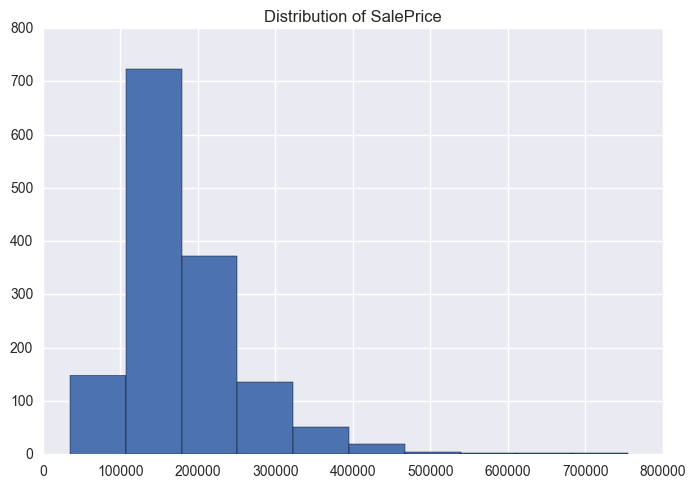

In [50]:
plt.title('Distribution of SalePrice')
plt.hist(train["SalePrice"])
plt.show()


The sale price has a skewed distribution. Moreover, the Kaggle metrics is mean square error between the log of the prices. So I apply a log transformation to this feature. From now on, we will be predicting log(SalePrice).

In [4]:
train["SalePrice"] = np.log1p(train["SalePrice"])

data=pd.concat([train, test], axis=0, join='outer',ignore_index=True)

print((data.shape))

(2919, 81)


In [5]:
numeric_feats = data.dtypes[data.dtypes != "object"].index #the numerical features
string_feats = data.dtypes[data.dtypes == "object"].index #the categorical features

<a id='video2'></a>
<a href='#video3'>Next step</a>

Now, the feature engineering. It is made in several steps.

1. Delete some outliers.
2. Add features. For instance, creating some features that are not linearly linked to the variables will be useful in the linear regression. 
3. Map the quality features with numbers.
4. Give neighborhood scores.
5. Exclude the rare modalities by binning them together (when it's meaningful). 
6. Unskew the skewed variables by applying a log transformation to them.
7. Replace categorical variables by dummies.

In [6]:

def feature_eng(data):
    # Delete outliers
    alldata=data.copy()
    alldata.drop(train[train["GrLivArea"] > 4000].index, inplace=True)

    for var in ["MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "GarageArea","BsmtFullBath","BsmtHalfBath","GarageYrBlt","PoolArea","GarageCars"]:
        alldata[var].fillna(0, inplace=True)
   

    #New features
    alldata['FloorRatio']=alldata['2ndFlrSF']/alldata['1stFlrSF']
    alldata['1stFlrSF_sqrt']=np.sqrt(alldata['1stFlrSF'])
    alldata['AgeHouse']=alldata['YrSold']-alldata['YearBuilt']
    alldata['SurfacePerCar']=(alldata['GarageArea']/alldata['GarageCars']).fillna(0)

    #How long ago was the last remodelling of the house ?
    alldata['AgeRemod'] = alldata['YrSold'] - alldata['YearRemodAdd']

    alldata['Baths'] = alldata['FullBath'] + alldata['HalfBath']
    alldata['BsmtBaths'] = alldata['BsmtFullBath'] + alldata['BsmtHalfBath']

    alldata['OverallQual_Square']=alldata['OverallQual']**2
    alldata['OverallCond_sqrt']=np.sqrt(alldata['OverallCond'])
    alldata['OverallCond_square']=alldata['OverallCond']**2
    alldata['OveralllTot']=alldata['OverallCond']*alldata['OverallQual']

    alldata['GrLivArea_Square']=alldata['GrLivArea']**2
    alldata['TotalBsmtSF_/GrLivArea']=alldata['TotalBsmtSF']/alldata['GrLivArea']
    alldata['LotArea_sqrt']=np.sqrt(alldata['LotArea'])
    alldata['TotRmsAbvGrd_sqrt']=np.sqrt(alldata['TotRmsAbvGrd'])    
    
    # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
    alldata["Remodeled"] = (alldata["YearRemodAdd"] != alldata["YearBuilt"]) * 1
    # Did a remodeling happen in the year the house was sold?
    alldata["RecentRemodel"] = (alldata["YearRemodAdd"] == alldata["YrSold"]) * 1
    # Was this house sold in the year it was built?
    alldata["VeryNewHouse"] = (alldata["YearBuilt"] == alldata["YrSold"]) * 1

        
    #Let's convert quality measurements to integers, using dictionaries    
    qualities_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    for var in ["ExterQual","ExterCond","BsmtQual","BsmtCond",
                "HeatingQC","KitchenQual","FireplaceQu",
                "GarageQual","GarageCond","PoolQC"]:
        alldata[var] = alldata[var].map(qualities_dict).astype(int)
        
    alldata["BsmtExposure"] = alldata["BsmtExposure"].map(
        {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

    bsmt_fin_dict = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    alldata["BsmtFinType1"] = alldata["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
    alldata["BsmtFinType2"] = alldata["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

    alldata["Functional"] = alldata["Functional"].map(
        {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

    alldata["GarageFinish"] = alldata["GarageFinish"].map(
        {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

    alldata["Fence"] = alldata["Fence"].map(
        {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)
    
    #We give every neighborhood a score that is the mean of the prices in the neighborhood
    neighb_dict=dict(alldata.groupby("Neighborhood").mean()["SalePrice"].sort_values())
    alldata['Neighborhood']=alldata['Neighborhood'].map(neighb_dict).astype(int)
    
    #We want to avoid having too many rare modalities because 
    # they are too rare too be accounted for during the prediction.
    alldata["IsLotShape_Reg"] = (alldata["LotShape"] == "Reg") * 1
    alldata["IsLandLevel"] = (alldata["LandContour"] == "Lvl") * 1
    alldata["IsLandSlope_Gentle"] = (alldata["LandSlope"] == "Gtl") * 1
    alldata["IsElectricalSBrkr"] = (alldata["Electrical"] == "SBrkr") * 1
    alldata["IsGarageDetached"] = (alldata["GarageType"] == "Detchd") * 1
    alldata["IsPavedDrive"] = (alldata["PavedDrive"] == "Y") * 1
    alldata["HasShed"] = (alldata["MiscFeature"] == "Shed") * 1.  
    alldata["IsGarageOld"]=(alldata["GarageYrBlt"]<=1950)*1
    alldata["GarageYrBlt"]=alldata["GarageYrBlt"]*(1-alldata["IsGarageOld"])
    alldata["Has2ndFloor"] = (alldata["2ndFlrSF"] == 0) * 1
    alldata["HasMasVnr"] = (alldata["MasVnrArea"] == 0) * 1
    alldata["HasWoodDeck"] = (alldata["WoodDeckSF"] == 0) * 1
    alldata["HasOpenPorch"] = (alldata["OpenPorchSF"] == 0) * 1
    alldata["HasEnclosedPorch"] = (alldata["EnclosedPorch"] == 0) * 1
    alldata["Has3SsnPorch"] = (alldata["3SsnPorch"] == 0) * 1
    alldata["HasScreenPorch"] = (alldata["ScreenPorch"] == 0) * 1
    
    numeric_feats = alldata.dtypes[alldata.dtypes != "object"].index
    alldata[numeric_feats]=alldata[numeric_feats].fillna(alldata[numeric_feats].median())


    skewed_feats = alldata[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75] #0.75 is an arbitrarly chosen value of skewness
    skewed_feats = skewed_feats.index

    #log transform the skewed numerical features:
    alldata[skewed_feats] = np.log1p(alldata[skewed_feats])

    # replace categorical variables by dummies
    alldata=pd.get_dummies(alldata,drop_first=True)
    print(alldata.shape)
    return alldata

In [7]:
alldata=feature_eng(data)
#alldata["SalePrice"]


(2915, 214)


<a id='visualization'></a>

# 2. Visualization

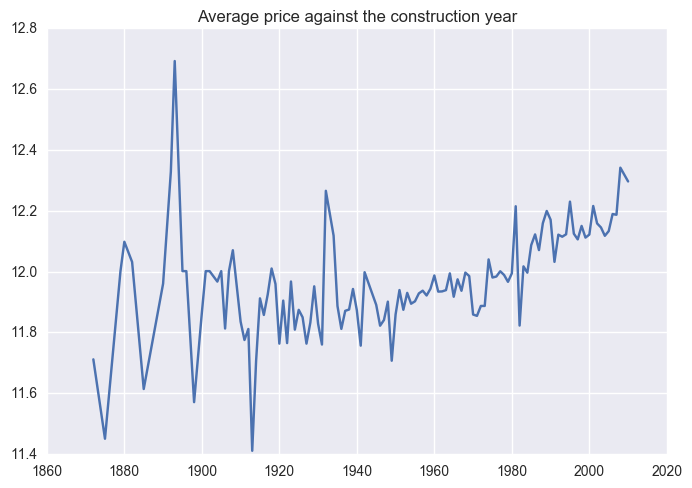

In [8]:
plt.plot(alldata.groupby("YearBuilt").mean()["SalePrice"])
plt.title("Average price against the construction year")
plt.show()

We can see that the more recently the house was built, the more expensive the house is, on average - except for very old houses where only have a few samples. 

In [9]:
#Correlation matrix
corr=train.corr()

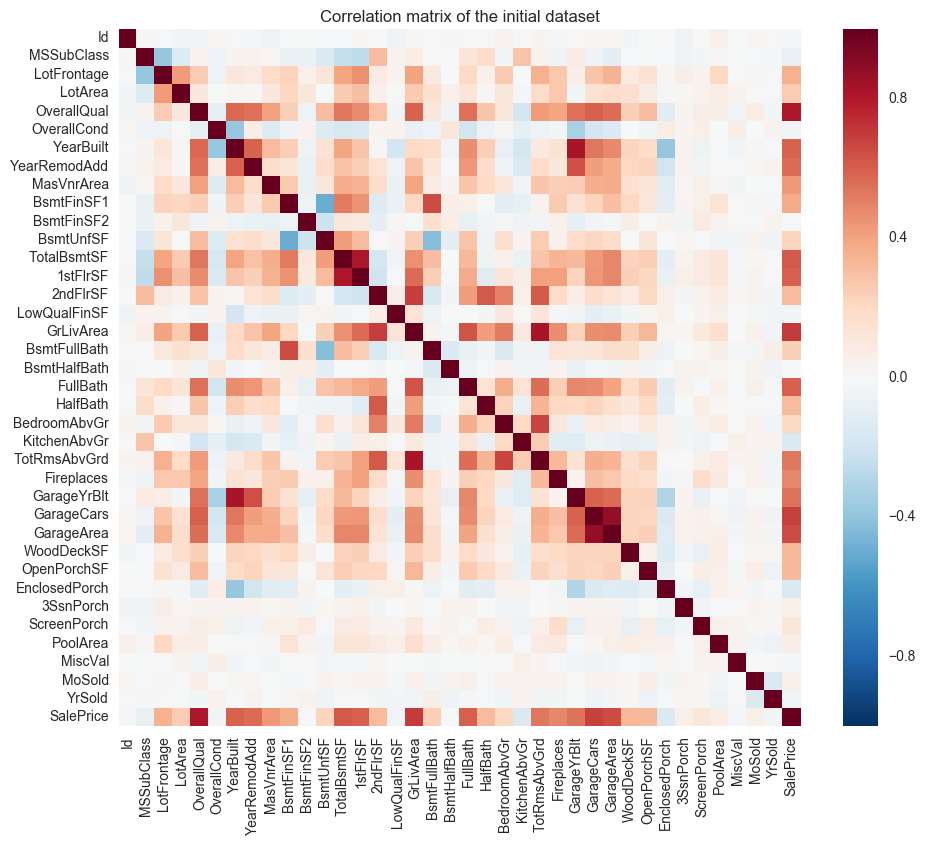

In [10]:

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
plt.title("Correlation matrix of the initial dataset")
sns.heatmap(corr,ax=ax)

<a id='video3'></a>
<a href='#video4'>Next step</a>

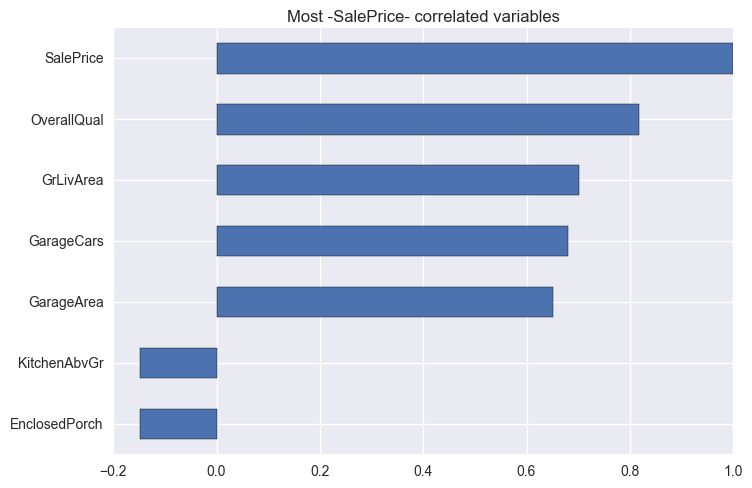

In [11]:
corr_sort=corr["SalePrice"].sort_values()
imp_coef = pd.concat([corr_sort.head(2), corr_sort.tail(5)])
imp_coef.plot(kind = "barh")
plt.title("Most -SalePrice- correlated variables")
plt.show()

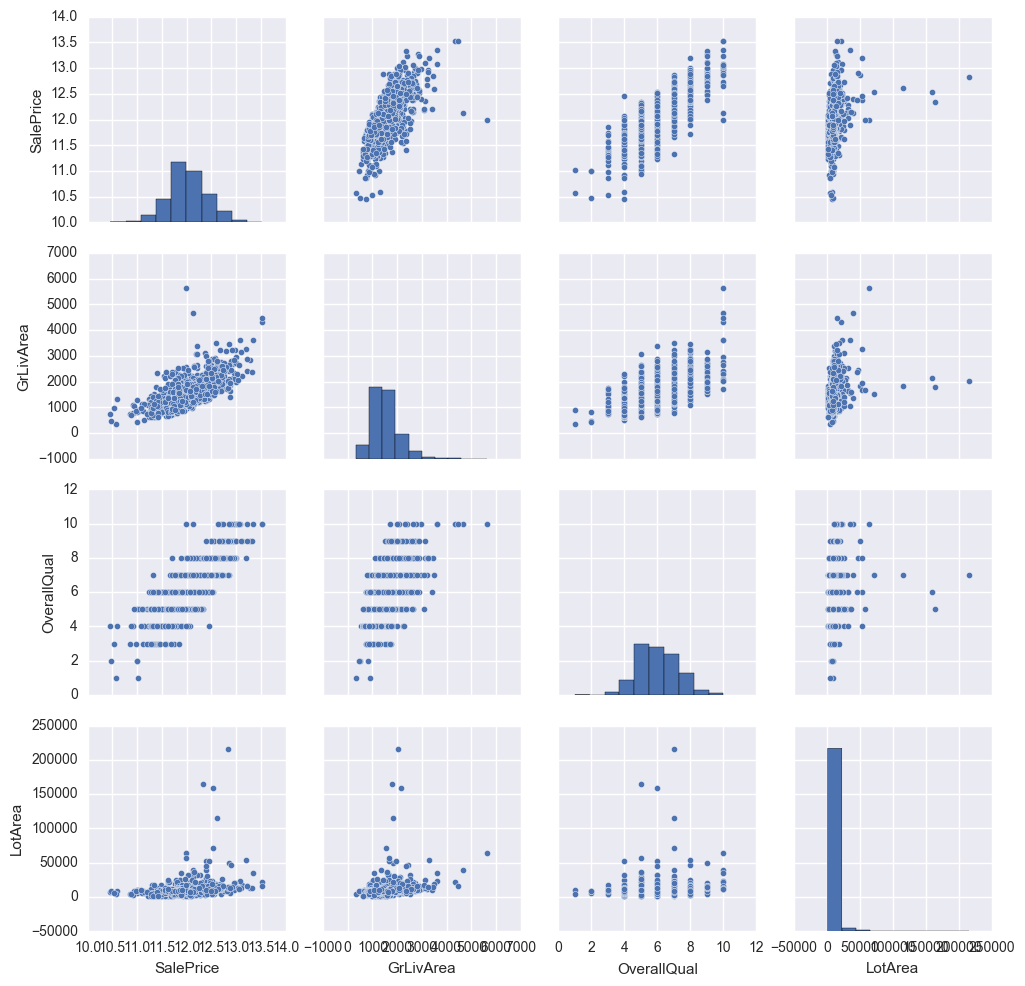

In [12]:
#Pairwise relations between the variables
sns.pairplot(train, vars=['SalePrice','GrLivArea','OverallQual','LotArea'])
plt.show()

It looks like the variables have linear relations with SalePrice. We will pursue a regression.

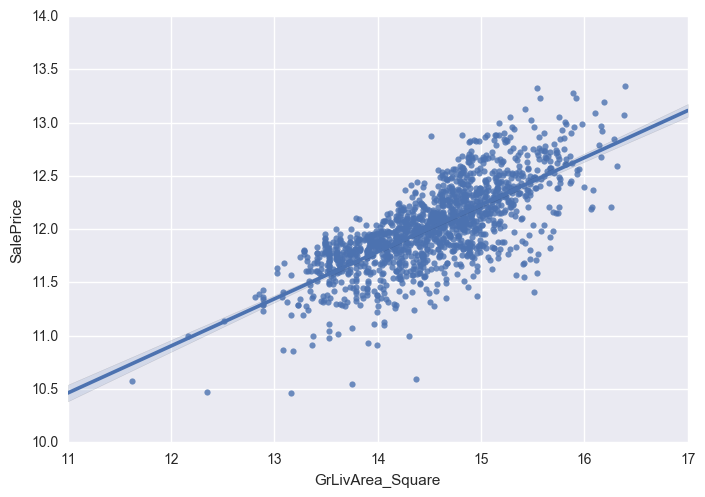

In [13]:
ax = sns.regplot(x="GrLivArea_Square", y="SalePrice", data=alldata.head(train_size))

I decided to add the variable GrLivArea_Square because when plotting GrLivArea against, the SalePrice seemed to be underrated for the large areas. (For information, GrLivArea is "Above grade (ground) living area square feet" ).

## Error metric


In [14]:

from sklearn.metrics import make_scorer, mean_squared_error

# simple error metric, as defined in the Kaggle competition description
def rmse_(ypred,ytest):
    return(np.sqrt(mean_squared_error(ypred,ytest)))

#cross validated error metric
def rmse_cv(model, X, y):
    scorer = make_scorer(rmse_, False)
    return (cross_validation.cross_val_score(model, X, y, scoring=scorer,cv=10)).mean()


<a id='prediction'></a>

# 3. Prediction 

## Separate data

In [15]:

features=alldata.columns.drop('SalePrice')
X=alldata.head(len(alldata)-test_size)[features]
y= alldata.head(len(alldata)-test_size)['SalePrice']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
     X , y, test_size=0.2, random_state=0)


<a id='lasso'></a>

## 3.1. Lasso with cross validation


<a id='video4'></a>
<a href='#video5'>Next step</a>

C:\Users\Yannick\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[-0.11501571509939482, -0.11346347165017354, -0.11309705390529232, -0.11371693253160826, -0.11452793185714956, -0.11506805375924403, -0.1162936333405189]
Cross val RMSE: 0.1131


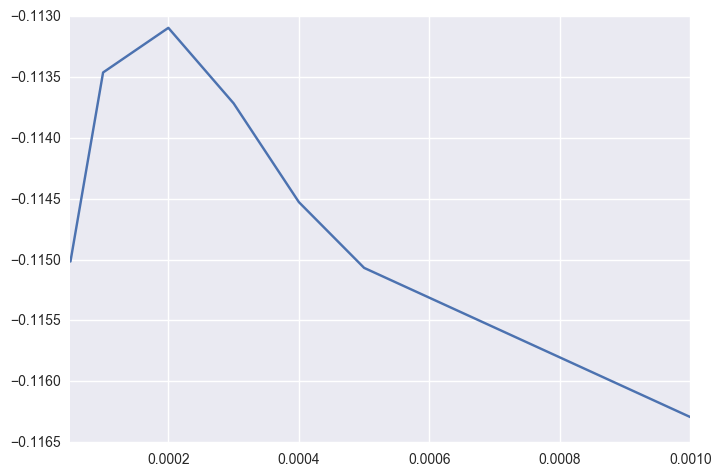

In [19]:

alphas = [5e-5, 1e-4,2e-4,3e-4,4e-4, 5e-4, 1e-3]

cv_lasso = [rmse_cv(Lasso(alpha = alpha), X, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()
best_alpha=alphas[np.argmax(cv_lasso)]

print(cv_lasso)
print("Cross val RMSE: %.4f" % abs(max(cv_lasso)))


In [20]:
model_lasso = Lasso(alpha=best_alpha).fit(X, y)
coef = pd.Series(model_lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 121 variables and eliminated the other 92 variables


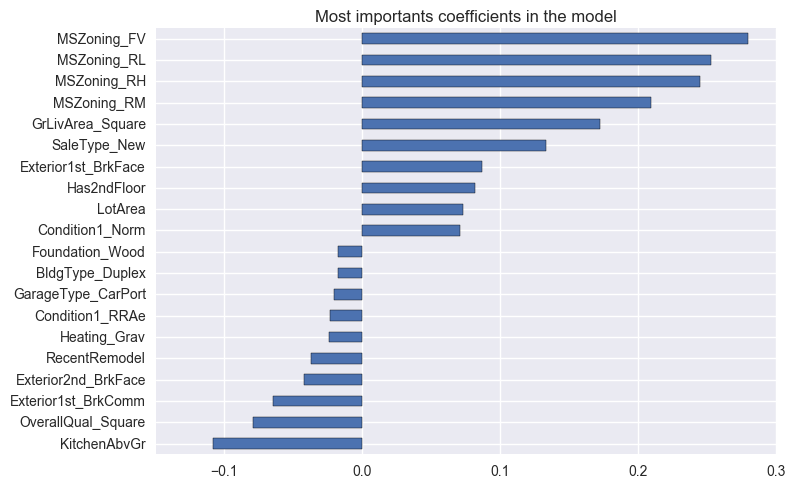

In [21]:
coef = coef.sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Most importants coefficients in the model")
plt.show()

<a id='gb'></a>

## 3.2. Gradient Boost and RFE

We have lots of variables. Lasso used to automatically select them by testing each of the variables significance. 
Let's use RFE (Recursive Feature Elimination) in order to plug it before the Gradient Boosting method.

In [24]:
from sklearn.feature_selection import RFE
n=100

# create the RFE model and select n attributes
gb = ensemble.GradientBoostingRegressor()
selector = RFE(gb, n, step=1)
selector = selector.fit(X, y)

In [25]:
X_transf=selector.transform(X)

gb.fit(X_transf,y)
print("Cross val RMSE: %.4f" % abs(rmse_cv(gb, X_transf, y)))


Cross val RMSE: 0.1213


Now let's see xgb which is similar but faster than sklearn's gradient boosting.

<a id='xgb'></a>

## 3.3. XGBoost

Let's first tune the hyperparameters using GridSearchCV.

In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_est=xgb.XGBClassifier()
parameters = {'max_depth':[2,3], 'learning_rate':[0.02,0.03,0.04 ,0.05],'n_estimators':[500]}
clf = GridSearchCV(xgb_est, parameters)
clf.fit(X,y)

clf.cv_results_

In [ ]:
clf.best_params_ # the result is :learning_rate= 0.02, max_depth= 3, n_estimators= 500

In [16]:
xgb_est=xgb.XGBRegressor(learning_rate= 0.02, max_depth= 3, n_estimators= 500)
print("Cross val RMSE: %.4f" % abs(rmse_cv(xgb_est, X, y)))


Cross val RMSE: 0.1205


In [17]:
xgb_est.fit(X,y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

<a id='combination'></a>

## 3.4. Combination

Mean of the lasso and the xgb predictions.

In [26]:
xgb_est.fit(X_train,y_train)
model_lasso.fit(X_train,y_train)
ypred_xgb_est=xgb_est.predict(X_test)
ypred_model_lasso=model_lasso.predict(X_test)

rmse_((ypred_model_lasso+ypred_xgb_est)/2,y_test)

0.10157235546856475

<a id='result_analysis'></a>

# 4.Result analysis

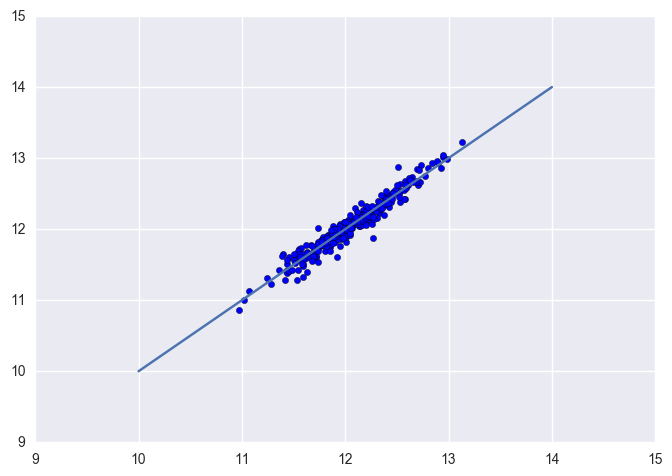

In [74]:
plt.scatter(model_lasso.predict(X_test),y_test)
plt.plot([10,14],[10,14])

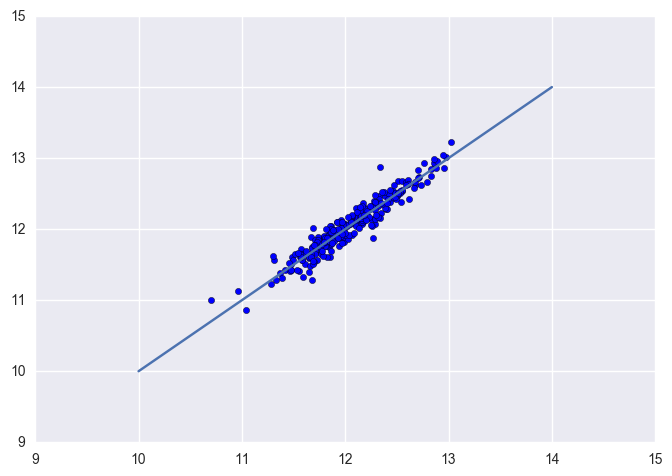

In [28]:
xgb_est.fit(X_train,y_train)
plt.scatter(xgb_est.predict(X_test),y_test)
plt.plot([10,14],[10,14])

Both models are never too far from the real log-price. It suggests that our model is quite robust.

# Comparison

In [29]:
models=[xgb_est,model_lasso]
scores=[]
for model in models:
    scores+=[rmse_cv(model,X,y)]
    
scores+=[rmse_cv(gb,X_transf,y)]    

([<matplotlib.axis.XTick at 0x11139588>,
 <a list of 3 Text xticklabel objects>)

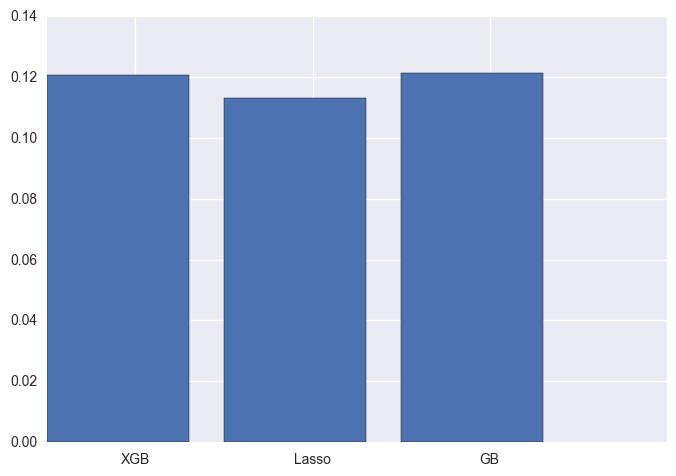

In [30]:
names=['XGB', 'Lasso','GB']
plt.bar(np.arange(3),np.abs(scores))
plt.xticks(np.arange(4)+0.5,names)

<a id='predict_train_test'></a>

## 5. Predict train/test

When I submit on Kaggle I have a poorer score than the one I have with cross validation. Let's see if the train and the test sets have different distributions. 

<a id='video5'> </a>
 .

In [31]:
data_intrain=alldata.copy()
data_intrain['intrain']=data_intrain['Id'].map(lambda x:int(x in train['Id']))
data_intrain=data_intrain.drop(['Id','SalePrice'],axis=1).sample(frac=1)

X_intrain=data_intrain.iloc[:,:-1]
y_intrain=data_intrain['intrain']

def rmse_cv_acc(model, X, y):
    scorer = make_scorer(accuracy_score, False)
    return (cross_validation.cross_val_score(model, X, y, scoring=scorer,cv=20)).mean()
xgb_est=xgb.XGBClassifier()
print("Cross val Accuracy: %.4f" % abs(rmse_cv_acc(xgb_est, X_intrain, y_intrain)))
#xgb_est.fit(data.iloc[:,:-1],data.iloc[:,-1])

Cross val Accuracy: 0.5143


The score is very close to 0.5 so we cannot predict whether an observation is from train or test. Train and test probably have the same distribution.

# Submit on Kaggle

In [101]:
xgb_est.fit(X,y)
model_lasso.fit(X,y)

ypred_lasso=model_lasso.predict(alldata.tail(test_size)[features])
ypred_xgb=xgb_est.predict(alldata.tail(test_size)[features])

df_submission=pd.DataFrame([])
df_submission['Id']=test['Id']
df_submission['SalePrice']=np.exp((ypred_xgb+ypred_lasso)/2)
df_submission.to_csv("house_regression_submission.csv", index=False)

In [102]:
df_submission

,Id,SalePrice
0,1461,116857.169998
1,1462,152900.346132
2,1463,174926.593513
3,1464,191882.712885
4,1465,195295.623214
5,1466,170511.263751
6,1467,175611.772058
7,1468,160778.109260
8,1469,194920.741836
9,1470,118406.670267


N.B. :
To write this notebook, I picked up some ideas found on the Kaggle forum : 

https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models/discussion

Conclusion: 
The model is quiet robust because it uses quite simple models: lasso regression and xgboost. The same model could probably be used in 5 years. However a few problems could require us to change our model:
- a high inflation or a price fall. We could multiply our prediction by the rate of inflation/deflation.
- the area where one wants to predict the house prices. This dataset is made with american houses, however the criteria may be  different in other countries.

Can we use this model in other configurations, where we would not have that much data about the houses? Yes, but we would have to retrain it. Fortunately, the model is cheap to train so it can easily be trained by anyone who wishes to predict the house prices given an appropriate dataset.


An idea of an application of this project would be an app/website that would scroll the web to extract some annoucements from which we would extract features of the houses. Then we would tell the customer if the annoucement he's interested is rather overpriced or underpriced.